In [4]:
import pandas as pd
import numpy as np

def load_stock_data(filename):
    # Reads the file (it can be tab or comma separated, adjust sep if needed)
    df = pd.read_csv(filename, sep=None, engine='python')

    # Clean column names (remove spaces and fix case)
    df.columns = [col.strip().capitalize() for col in df.columns]

    # Parse 'Time' column as datetime
    df['Datetime'] = pd.to_datetime(df['Time'])
    df.drop(columns=['Time', 'Volume'], inplace=True)

    # Set as index and sort
    df.set_index('Datetime', inplace=True)
    df.sort_index(inplace=True)


    return df

# Example usage
df = load_stock_data('EURUSD_15m_BID_01.01.2010-31.12.2016.csv')
print(df.head())

                        Open     High      Low    Close
Datetime                                               
2010-01-01 00:00:00  1.43283  1.43293  1.43224  1.43293
2010-01-01 00:15:00  1.43285  1.43295  1.43229  1.43275
2010-01-01 00:30:00  1.43280  1.43303  1.43239  1.43281
2010-01-01 00:45:00  1.43285  1.43294  1.43229  1.43276
2010-01-01 01:00:00  1.43287  1.43292  1.43206  1.43282


##### 2019-01-01 and 2019-04-30 4 hour data

c:\Users\user\miniconda3\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


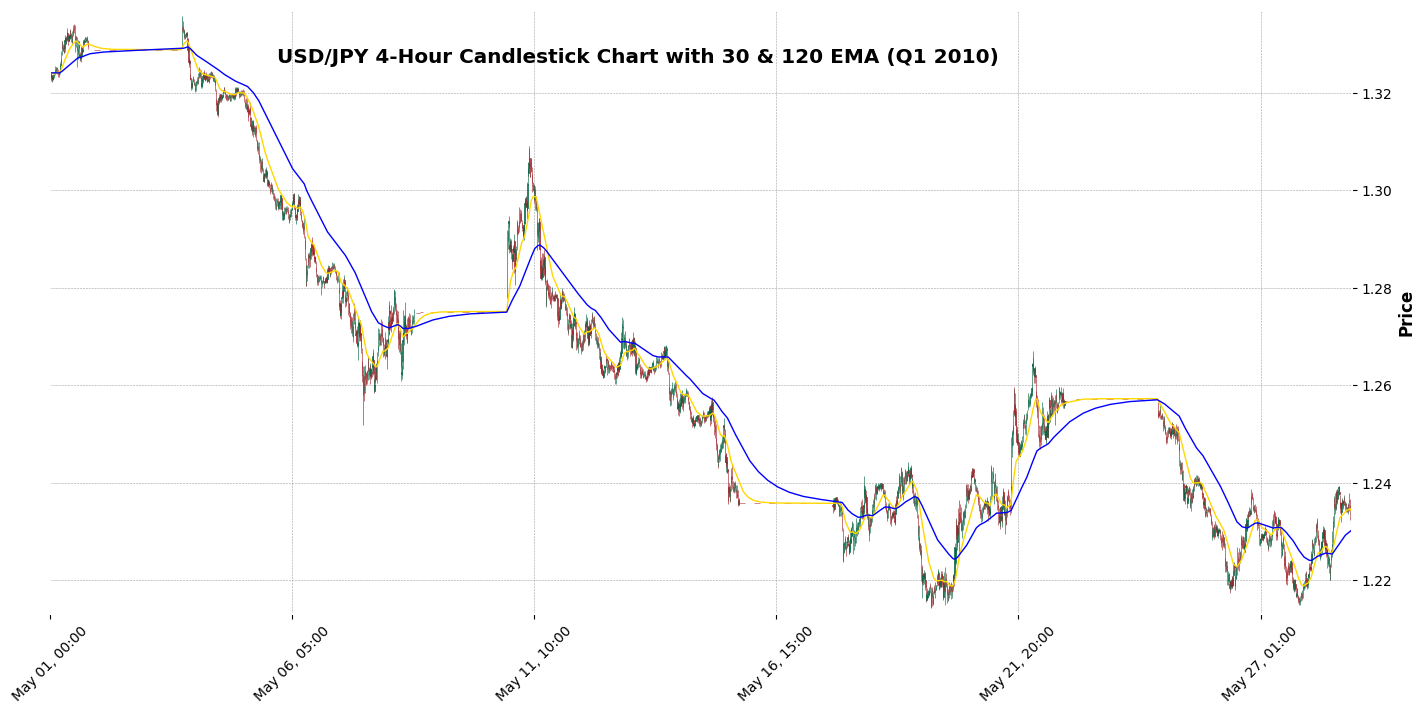

In [5]:
import pandas as pd
import mplfinance as mpf

# Filter 2019 Q1 using datetime index
df_2019_q1 = df[(df.index >= '2010-05-01') & (df.index <= '2010-05-29')].copy()

"""  
# Resample to 4-hour intervals
df_4h = df_2019_q1.resample('4H').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}).dropna()

"""
df_4h = df_2019_q1.copy()

# Calculate 30 and 120 period EMAs on 'Close'
df_4h['EMA_30'] = df_4h['Close'].ewm(span=30, adjust=False).mean()
df_4h['EMA_120'] = df_4h['Close'].ewm(span=120, adjust=False).mean()

df_4h['trend'] = np.where(df_4h['EMA_30'] > df_4h['EMA_120'], 'bullish', 
                    np.where(df_4h['EMA_30'] < df_4h['EMA_120'],'bearish', np.nan))
df_4h["Green"] = np.select(
    [df_4h["Close"] > df_4h["Open"], df_4h["Close"] < df_4h["Open"]],
    [True, False],
    default=pd.NA
).astype("object")  # <- 'boolean' not 'bool'
df["label"] = None
df["label"] = df["label"].astype(object)

# Plot candlestick chart with EMAs
mpf.plot(df_4h[['Open', 'High', 'Low', 'Close']],
         type='candle',
         style='charles',
         title='USD/JPY 4-Hour Candlestick Chart with 30 & 120 EMA (Q1 2010)',
         ylabel='Price',
         volume=False,
         figsize=(15, 7),
         tight_layout=True,
         addplot=[
             mpf.make_addplot(df_4h['EMA_30'], color='gold', width=1),
             mpf.make_addplot(df_4h['EMA_120'], color='blue', width=1)
         ])


#### Fib

In [6]:
print(df_4h[0:])

                        Open     High      Low    Close    EMA_30   EMA_120  \
Datetime                                                                      
2010-05-01 00:00:00  1.32333  1.32488  1.32309  1.32414  1.324140  1.324140   
2010-05-01 00:15:00  1.32396  1.32421  1.32335  1.32347  1.324097  1.324129   
2010-05-01 00:30:00  1.32335  1.32392  1.32304  1.32374  1.324074  1.324122   
2010-05-01 00:45:00  1.32362  1.32370  1.32250  1.32296  1.324002  1.324103   
2010-05-01 01:00:00  1.32283  1.32301  1.32222  1.32280  1.323924  1.324082   
...                      ...      ...      ...      ...       ...       ...   
2010-05-28 23:00:00  1.23658  1.23664  1.23488  1.23519  1.234752  1.230068   
2010-05-28 23:15:00  1.23511  1.23535  1.23236  1.23326  1.234656  1.230121   
2010-05-28 23:30:00  1.23309  1.23340  1.23203  1.23339  1.234574  1.230175   
2010-05-28 23:45:00  1.23340  1.23399  1.23149  1.23195  1.234405  1.230205   
2010-05-29 00:00:00  1.23181  1.23213  1.22999  1.23

In [7]:
print(df_4h.columns)


Index(['Open', 'High', 'Low', 'Close', 'EMA_30', 'EMA_120', 'trend', 'Green'], dtype='object')


In [8]:
import matplotlib.patches as patches

def plot_fibonacci_candlestick(df, start_idx, end_idx, levels=None, trend="bearish", entry_signal=None, engulfing_candle=None, R=None, pip_size=0.0010):

    if levels is None:
        levels = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]

    df_slice = df.iloc[start_idx:end_idx + 2 + 1].copy()
    min_price = df_slice['Low'].min()
    max_price = df_slice['High'].max()

    fib_lines = []
    fib_labels = []

    for level in levels:
        if trend == "bearish":
            y = min_price + (max_price - min_price) * level
        else:
            y = max_price - (max_price - min_price) * level

        line_data = [np.nan] * len(df)
        line_data[start_idx:end_idx + 1] = [y] * (end_idx - start_idx + 1)

        fib_lines.append(mpf.make_addplot(
            line_data,
            color='gray', linestyle='--', width=0.7
        ))

        fib_labels.append((level, y))

    # Add EMAs
    ema_30_plot = mpf.make_addplot(df['EMA_30'], color='gold', width=1.2, panel=0)
    ema_120_plot = mpf.make_addplot(df['EMA_120'], color='blue', width=1.2, panel=0)

    all_addplots = fib_lines + [ema_30_plot, ema_120_plot]

    # Entry Signal
    if entry_signal is not None and 0 <= entry_signal < len(df):
        entry_price = df['Close'].iloc[entry_signal]
        marker = '^' if trend == "bullish" else 'v'
        color = 'green' if trend == "bullish" else 'red'
        signal_plot = mpf.make_addplot(
            [entry_price if i == entry_signal else np.nan for i in range(len(df))],
            type='scatter',
            markersize=100,
            marker=marker,
            color=color
        )
        all_addplots.append(signal_plot)
    
    # Determine plotting range
    plot_buffer = 40
    plot_start = max(0, start_idx - plot_buffer)
    plot_end = min(len(df) - 1, end_idx + plot_buffer + 2)

    # Slice local region for plotting and Y-axis range
    df_slice_plot = df.iloc[plot_start:plot_end + 1].copy()

    # Plot candlestick chart first
    fig, axlist = mpf.plot(df,
                           type='candle',
                           style='yahoo',
                           addplot=all_addplots,
                           title='Fibonacci Retracement with EMA and Reward Box',
                           ylabel='Price',
                           volume=False,
                           returnfig=True,
                           warn_too_much_data=10000)

    ax = axlist[0]
    # ✅ Set local X-axis limits (index range)
    ax.set_xlim(plot_start, plot_end)

    # ✅ Set local Y-axis limits (based on High/Low in local range)
    local_min = df_slice_plot['Low'].min()
    local_max = df_slice_plot['High'].max()
    price_padding = 0.01 * (local_max - local_min)  # Add 1% padding for readability
    ax.set_ylim(local_min - price_padding, local_max + price_padding)

    # ✅ Reward box drawing only if engulfing_candle is not None
    if R is not None and engulfing_candle is not None:
        candle = df.iloc[engulfing_candle]
        close_price = candle['Close']

        # Box width (horizontal span)
        box_left = engulfing_candle - 1
        box_right = engulfing_candle + 10
        width = box_right - box_left

        # --- Red Box (Risk area) ---
        red_top = close_price + pip_size
        red_bottom = close_price
        red_height = abs(red_top - red_bottom)
        red_y = min(red_top, red_bottom)

        red_box = patches.Rectangle(
            (box_left, red_y),
            width,
            red_height,
            linewidth=0,
            edgecolor=None,
            facecolor='red',
            alpha=0.3,
            zorder=0
        )
        ax.add_patch(red_box)

        # --- Green Box (Reward area) ---
        green_top = close_price
        green_bottom = close_price - R * pip_size
        green_height = abs(green_top - green_bottom)
        green_y = min(green_top, green_bottom)

        green_box = patches.Rectangle(
            (box_left, green_y),
            width,
            green_height,
            linewidth=0,
            edgecolor=None,
            facecolor='green',
            alpha=0.3,
            zorder=0
        )
        ax.add_patch(green_box)
    

    # Annotate Fib levels
    for level, y in fib_labels:
        label_text = f"{level:.3f}"
        ax.annotate(label_text,
                    xy=(end_idx, y),
                    xytext=(5, 0),
                    textcoords='offset points',
                    ha='left',
                    va='center',
                    fontsize=8,
                    color='gray')
    
    # 🔍 Annotate any labels in the df['label'] column
    for i in range(plot_start, plot_end + 1):
        label = df['label'].iloc[i]
        if pd.notna(label) and str(label).strip() != "":
            y = df['High'].iloc[i] + 0.5 * price_padding  # Place label above the candle
            ax.annotate(str(label),
                        xy=(i, y),
                        xytext=(0, 0),
                        textcoords='offset points',
                        ha='center',
                        va='bottom',
                        fontsize=8,
                        color='black',
                        rotation=0)

    plt.show()
    return fib_labels


##### Detect peak / trough

[7] State changed: IDLE → PULLBACK_DETECTED
[14] Trend changed from bearish to bullish, reset state to IDLE
[290] Trend changed from bullish to bearish, reset state to IDLE
[295] State changed: IDLE → PULLBACK_DETECTED
[341] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


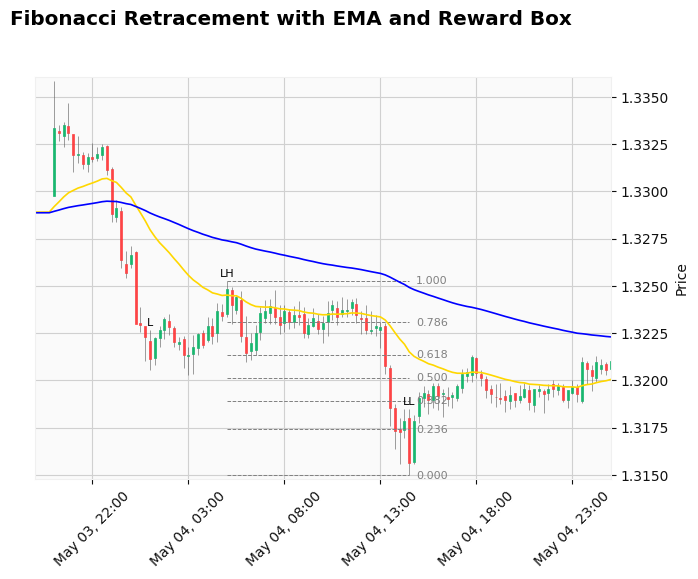

[349] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[414] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


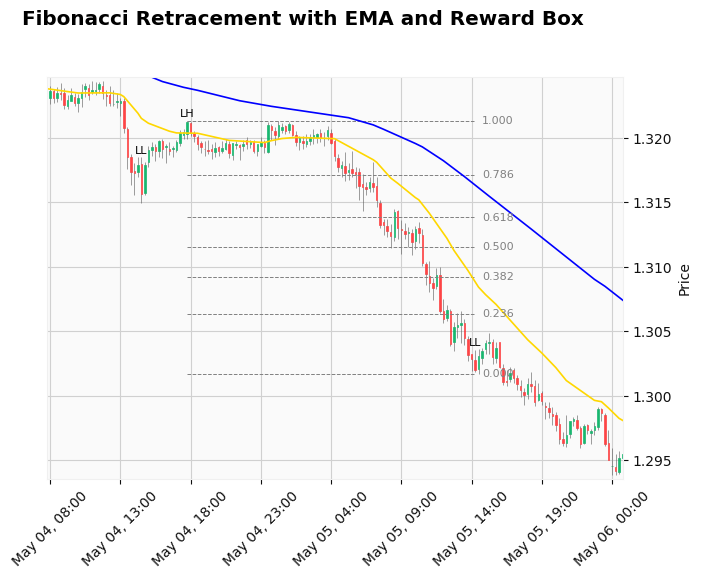

[444] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[449] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


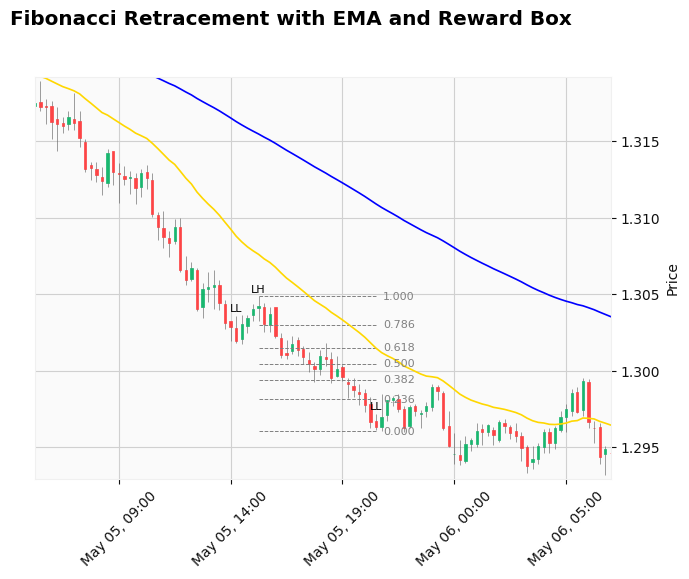

[469] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[479] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


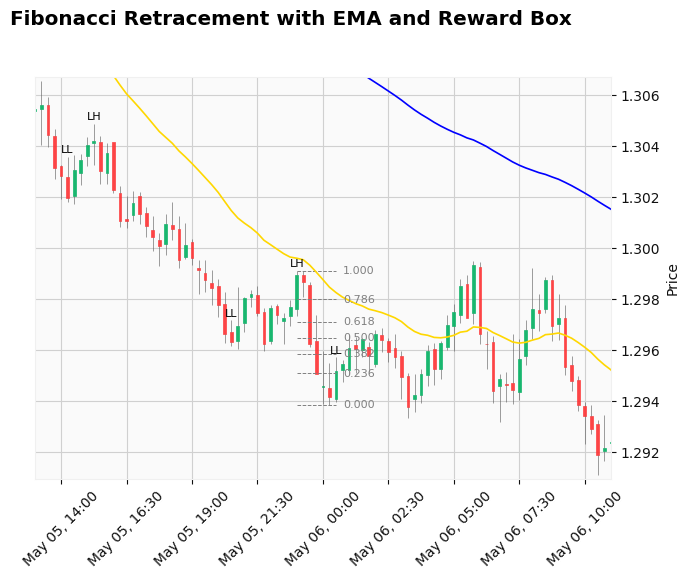

[484] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[493] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE
[496] State changed: BREAK_OF_STRUCTURE → PULLBACK_DETECTED
[519] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


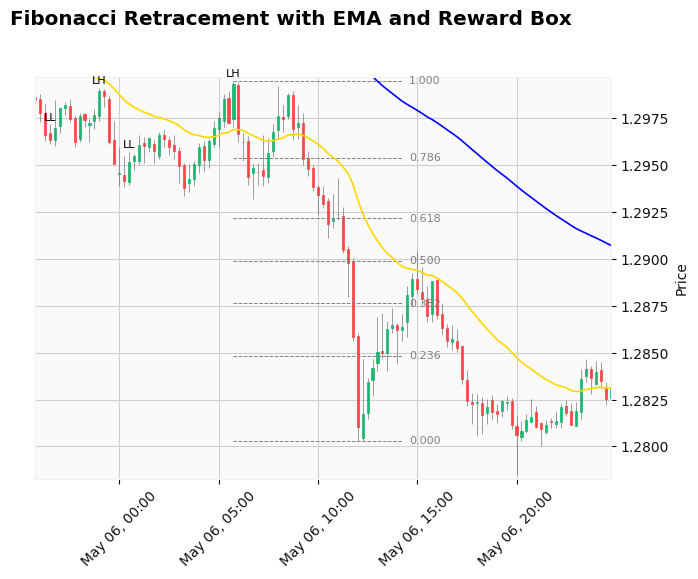

[539] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[596] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


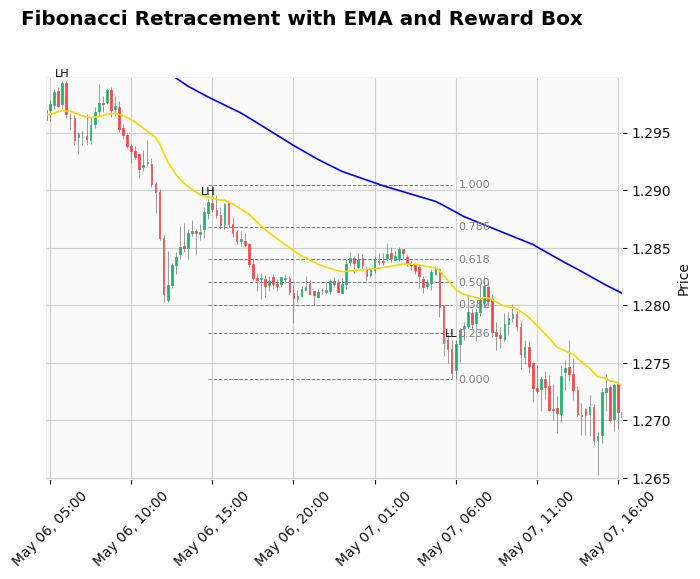

[602] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[619] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


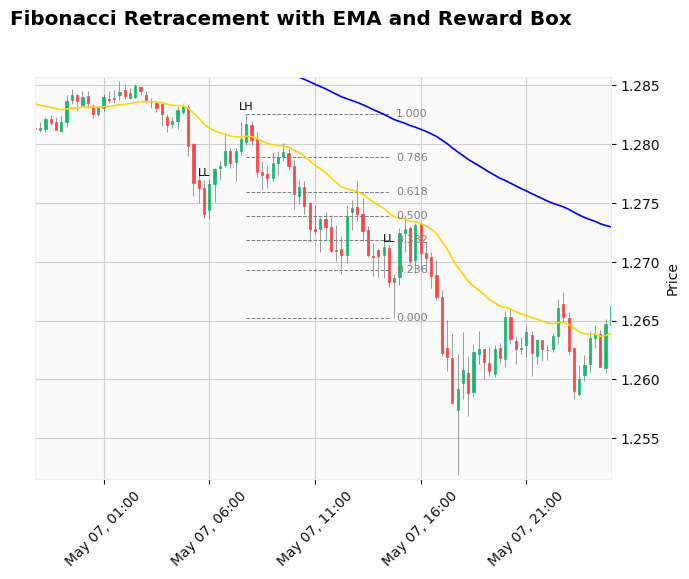

[637] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[644] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


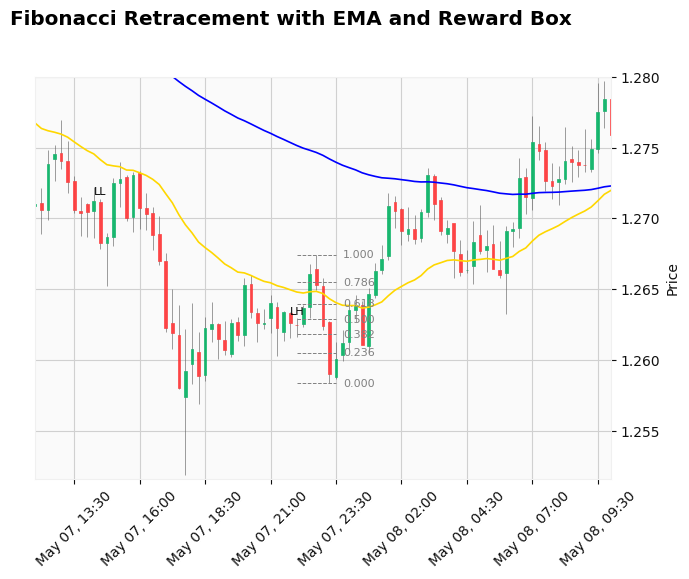

[672] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


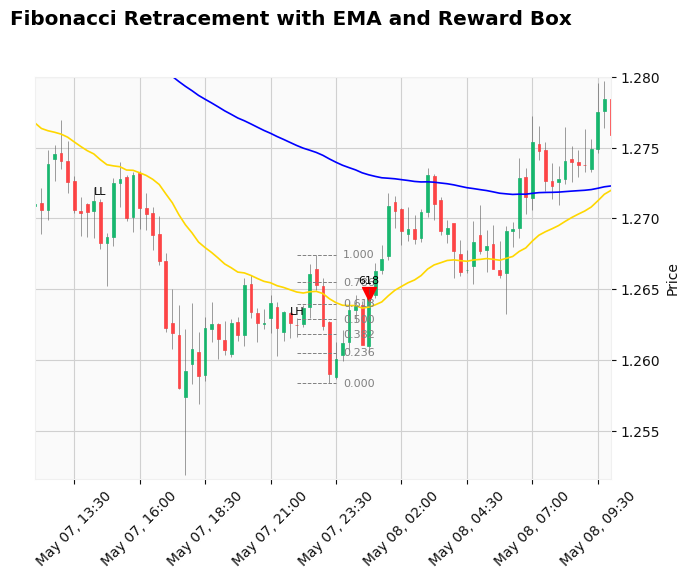

[675] State changed: WAITING_ENTRY → ENTRY_SIGNAL
[678] State changed: ENTRY_SIGNAL → PULLBACK_DETECTED
[714] Trend changed from bearish to bullish, reset state to IDLE
[720] Trend changed from bullish to bearish, reset state to IDLE
[728] State changed: IDLE → PULLBACK_DETECTED
[751] Trend changed from bearish to bullish, reset state to IDLE
[1026] Trend changed from bullish to bearish, reset state to IDLE
[1053] State changed: IDLE → PULLBACK_DETECTED
[1068] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


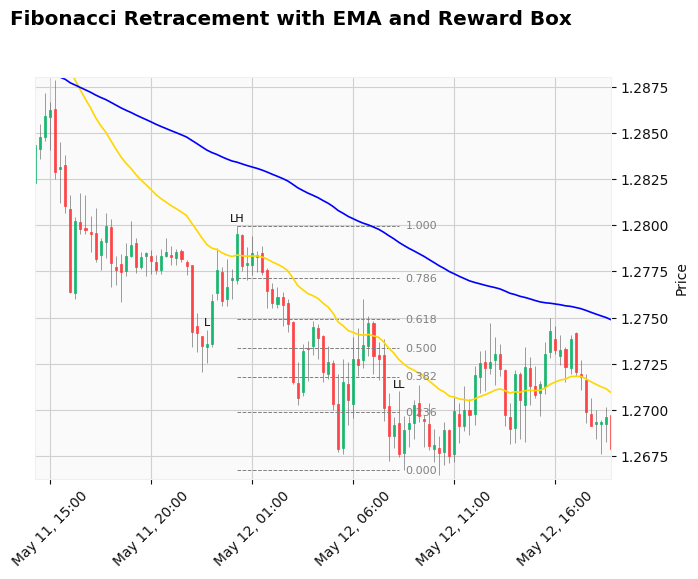

[1092] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[1134] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


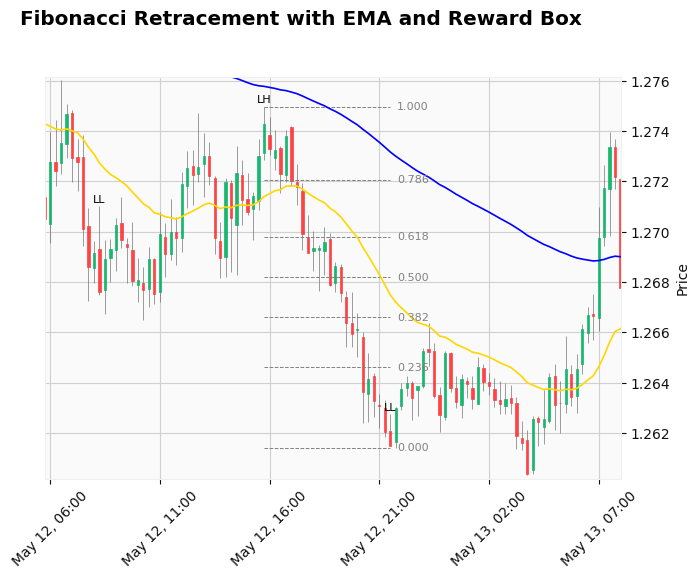

[1145] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[1167] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE
[1178] State changed: BREAK_OF_STRUCTURE → PULLBACK_DETECTED
[1231] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE
[1243] State changed: BREAK_OF_STRUCTURE → PULLBACK_DETECTED
[1278] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


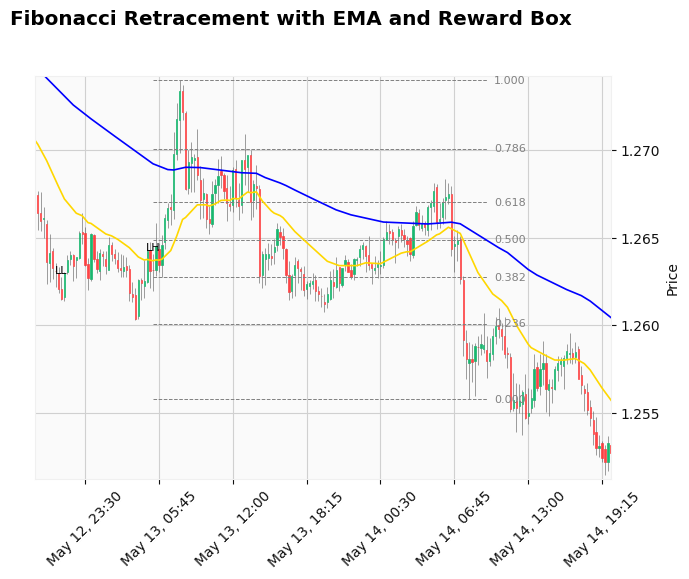

[1289] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[1294] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


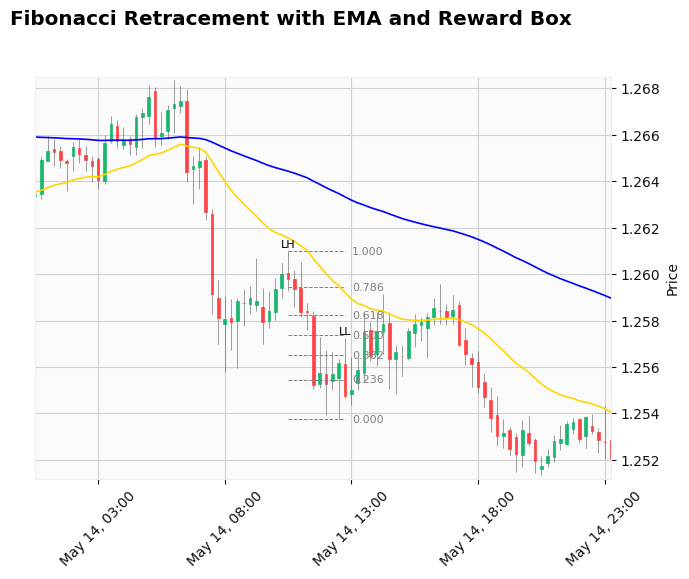

[1302] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


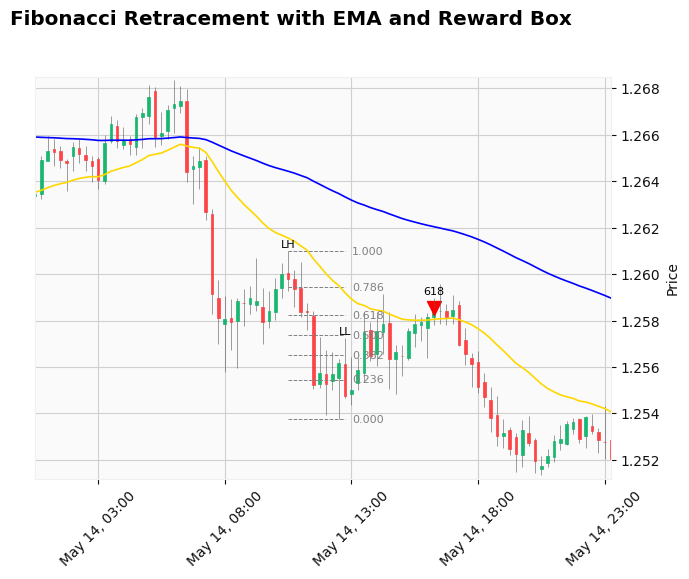

[1313] State changed: WAITING_ENTRY → ENTRY_SIGNAL


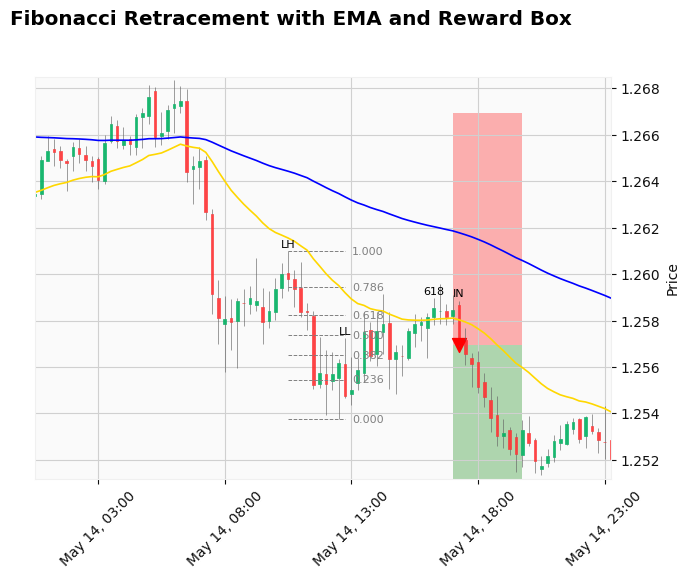

[1317] State changed: ENTRY_SIGNAL → ENTER_MARKET
[1318] Reached ENTER_MARKET — resetting FSM to IDLE
[1346] State changed: IDLE → PULLBACK_DETECTED
[1372] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


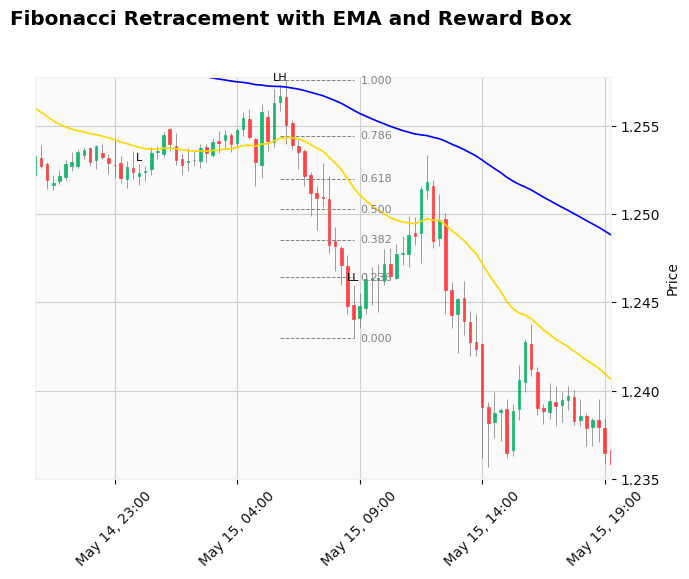

[1382] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[1398] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


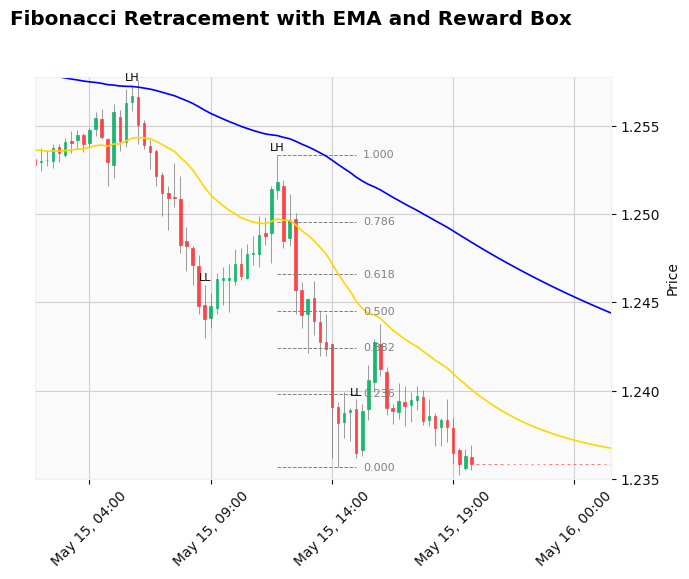

[1407] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[1422] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


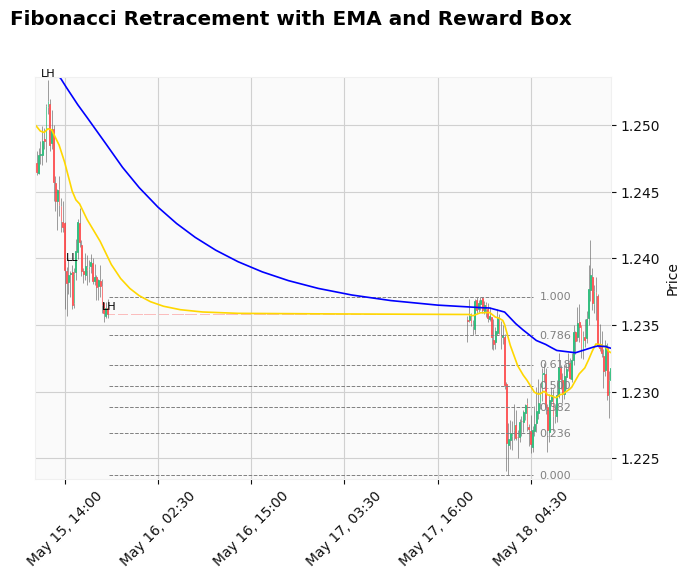

[1653] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


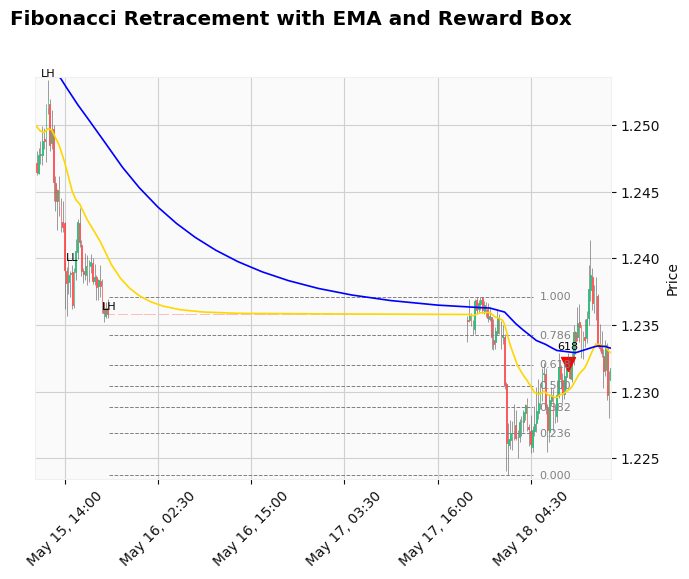

[1670] State changed: WAITING_ENTRY → ENTRY_SIGNAL


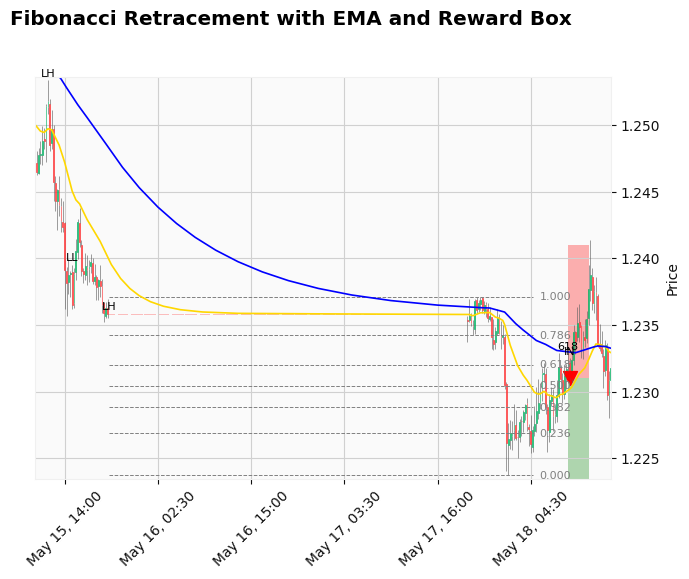

[1671] State changed: ENTRY_SIGNAL → ENTER_MARKET
[1672] Reached ENTER_MARKET — resetting FSM to IDLE
[1682] State changed: IDLE → PULLBACK_DETECTED
[1685] Trend changed from bearish to bullish, reset state to IDLE
[1691] Trend changed from bullish to bearish, reset state to IDLE
[1697] State changed: IDLE → PULLBACK_DETECTED
[1701] Trend changed from bearish to bullish, reset state to IDLE
[1744] Trend changed from bullish to bearish, reset state to IDLE
[1747] Trend changed from bearish to bullish, reset state to IDLE
[1794] Trend changed from bullish to bearish, reset state to IDLE
[1825] State changed: IDLE → PULLBACK_DETECTED
[1879] Trend changed from bearish to bullish, reset state to IDLE
[2289] Trend changed from bullish to bearish, reset state to IDLE
[2362] State changed: IDLE → PULLBACK_DETECTED
[2380] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


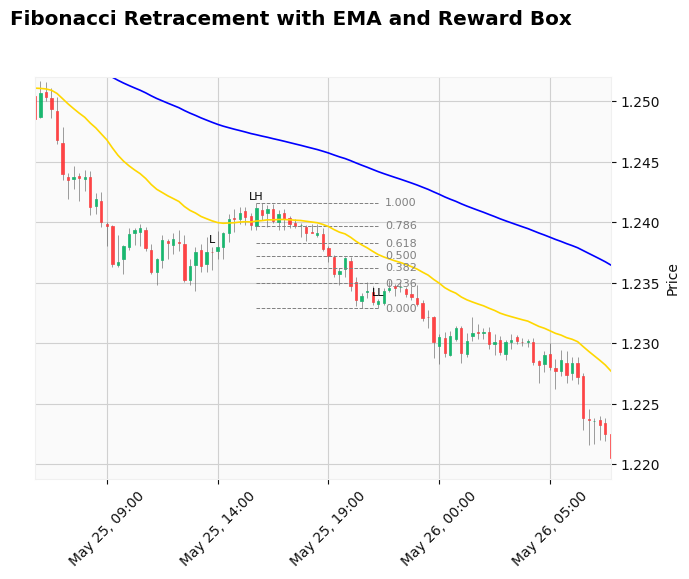

[2391] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[2397] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


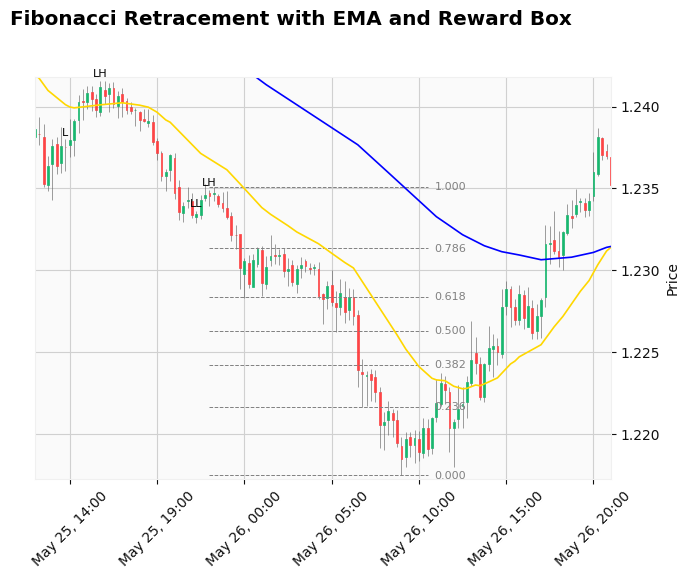

[2445] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


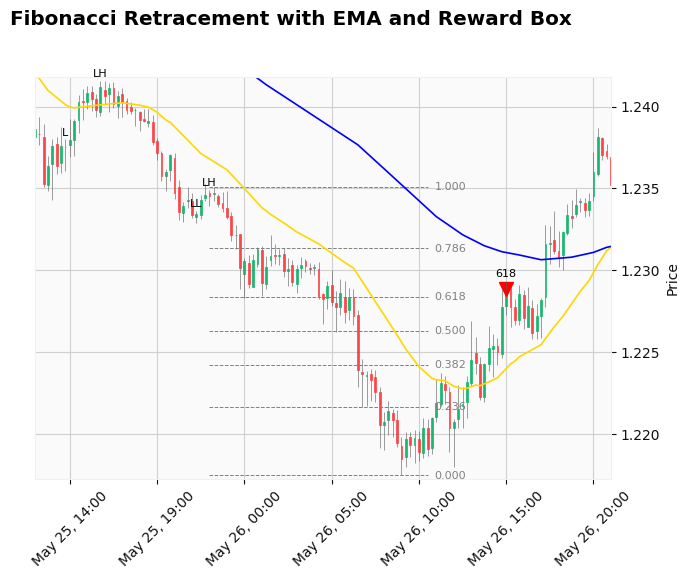

[2460] State changed: WAITING_ENTRY → ENTRY_SIGNAL


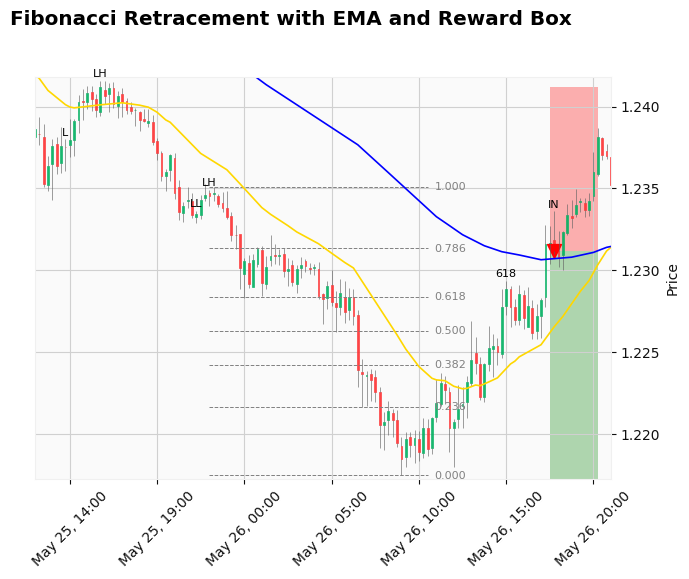

[2471] State changed: ENTRY_SIGNAL → ENTER_MARKET
[2472] Reached ENTER_MARKET — resetting FSM to IDLE
[2481] State changed: IDLE → PULLBACK_DETECTED
[2485] Trend changed from bearish to bullish, reset state to IDLE
[2499] Trend changed from bullish to bearish, reset state to IDLE
[2508] State changed: IDLE → PULLBACK_DETECTED
[2512] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE
[2524] State changed: BREAK_OF_STRUCTURE → PULLBACK_DETECTED
[2543] State changed: PULLBACK_DETECTED → BREAK_OF_STRUCTURE


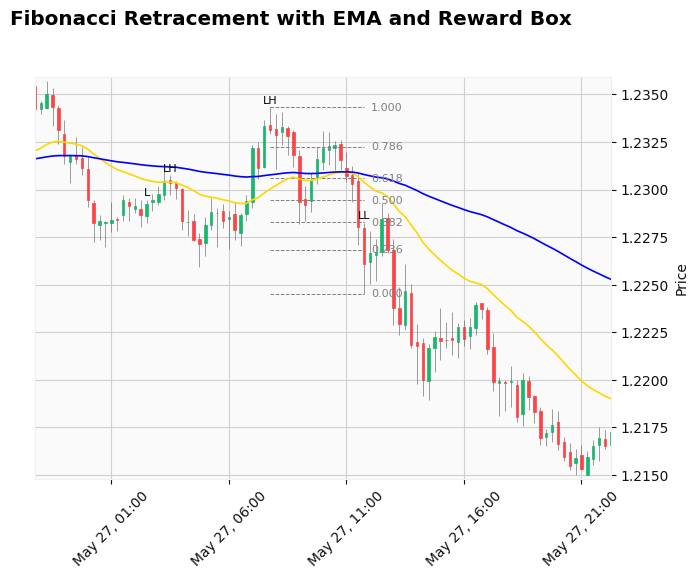

[2546] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY
[2548] State changed: WAITING_ENTRY → BREAK_OF_STRUCTURE


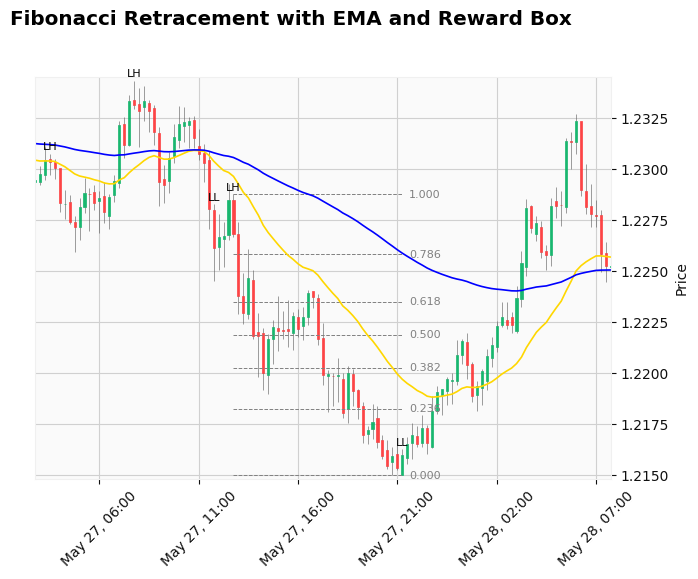

[2583] State changed: BREAK_OF_STRUCTURE → WAITING_ENTRY


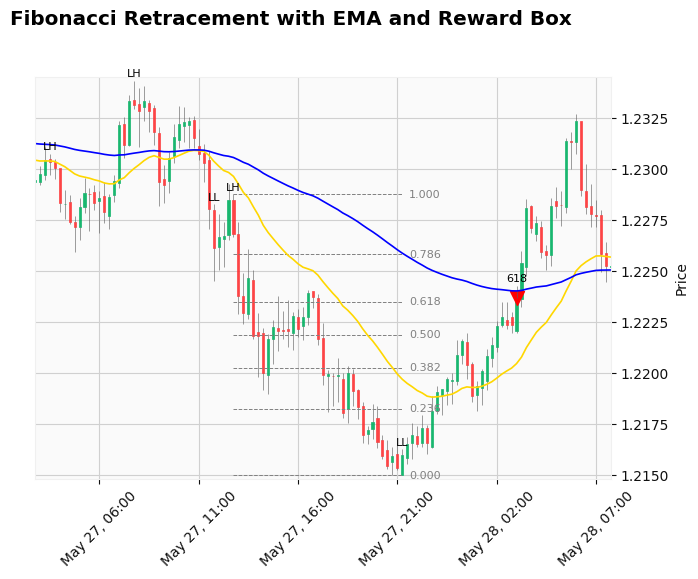

[2604] State changed: WAITING_ENTRY → ENTRY_SIGNAL
[2614] State changed: ENTRY_SIGNAL → PULLBACK_DETECTED
[2616] Trend changed from bearish to bullish, reset state to IDLE


In [18]:
import matplotlib.pyplot as plt

class BearishFSM: # Finite State Machine
    def __init__(self, df):
        self.df = df
        self.state = "IDLE"
        self.low_price = None
        self.low_price_relative_idx = None
        self.low_price_idx = None
        self.high_price = None
        self.high_price_idx = None
        self.high_price_relative_idx = None
        self.fib_labels = []
        self.fib_dict = {} # not a must to initialize, just for good habit
        self.entry_signal_idx = None
        

    def update(self, idx):
        trend = self.df['trend'].values
        greens = self.df["Green"]
        opens = self.df["Open"].values
        closes = self.df["Close"].values
        lowest_body_price = np.select([greens == True, greens == False], [opens, closes], default=np.nan) # array-based logic, avoid direct truthiness check
        highest_body_price = np.select([greens == True, greens == False], [closes, opens], default=np.nan) # default=np.nan ensures that rows where "Green" is missing won't cause errors
        

        current_trend = trend[idx]
        prev_trend = trend[idx - 1]

        if current_trend != prev_trend:
            self.reset()
            print(f"[{idx}] Trend changed from {prev_trend} to {current_trend}, reset state to IDLE")

        if current_trend == "bearish":
            if self.state == "IDLE":
                if all(greens.iloc[idx - i] is True for i in range(3)) and (greens.iloc[idx - 3] is False) and (closes[idx] > opens[idx - 3] or closes[idx - 1] > opens[idx - 3] or closes[idx - 2] > opens[idx - 3]): # pullback should eat and cover the previous red candle
                    self.low_price = lowest_body_price[idx-3:idx+1].min()
                    self.low_price_relative_idx = np.argmin(lowest_body_price[idx-3: idx+1])
                    self.low_price_idx = (idx - 3) + self.low_price_relative_idx
                    prev_state = self.state
                    self.df.loc[self.df.index[self.low_price_idx], "label"] = 'L'
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "PULLBACK_DETECTED":
                if lowest_body_price[idx] < self.low_price:

                    self.high_price = highest_body_price[self.low_price_idx:idx].max()
                    self.high_price_relative_idx = np.argmax(highest_body_price[self.low_price_idx: idx])
                    self.high_price_idx = self.low_price_idx + self.high_price_relative_idx

                    # Identify Lower High
                    self.df.loc[self.df.index[self.high_price_idx], "label"] = 'LH'

                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "BREAK_OF_STRUCTURE":
                # If price breaks the pev high (LH)
                if highest_body_price[idx] > self.high_price:

                    self.low_price = lowest_body_price[self.high_price_idx:idx].min()
                    self.low_price_relative_idx = np.argmin(lowest_body_price[self.high_price_idx: idx])
                    self.low_price_idx = self.high_price_idx + self.low_price_relative_idx

                    # We identify the Higher Low (HL)
                    # self.df.loc[self.df.index[self.low_price_idx], "label"] = 'HL'
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

                elif all(greens.iloc[idx - i] is True for i in range(3)) and (greens.iloc[idx - 3] is False) and (closes[idx] > opens[idx - 3] or closes[idx - 1] > opens[idx - 3] or closes[idx - 2] > opens[idx - 3]):
                    
                    if lowest_body_price[idx] < self.low_price:
                        # Define high price for Fib retrace
                        self.high_price = highest_body_price[self.low_price_idx:idx - 2].max()
                        self.high_price_relative_idx = np.argmax(highest_body_price[self.low_price_idx: idx - 2])
                        self.high_price_idx = self.low_price_idx + self.high_price_relative_idx

                        # Identify LH
                        
                        self.df.loc[self.df.index[self.high_price_idx], "label"] = 'LH'

                        # Low price for confirming the next Lower high
                        self.low_price = lowest_body_price[idx-3:idx+1].min()
                        self.low_price_relative_idx = np.argmin(lowest_body_price[idx-3: idx+1])
                        self.low_price_idx = (idx - 3) + self.low_price_relative_idx

                        # Identify LL only if the current price is the lowest price in the fib retracement
                        if self.low_price == lowest_body_price[self.high_price_idx:idx+1].min():
                            self.df.loc[self.df.index[self.low_price_idx], "label"] = 'LL'

                        self.fib_labels = plot_fibonacci_candlestick(self.df, self.high_price_idx, self.low_price_idx, trend="bearish")
                        self.fib_dict = dict(self.fib_labels)
                        prev_state = self.state
                        self.state = "WAITING_ENTRY"
                        print(f"[{idx}] State changed: {prev_state} → {self.state}")

                    elif highest_body_price[idx] >= self.low_price:
                        # bullish trend
                        # self.df.loc[self.df.index[idx], "label"] = 'HL'
                        prev_state = self.state
                        self.state = "PULLBACK_DETECTED"
                        print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "WAITING_ENTRY":
                fib_618_price = self.fib_dict.get(0.618)
                fib_000_price = self.fib_dict.get(0.000)
                if fib_618_price and highest_body_price[idx] >= fib_618_price: # price rebound back to 0.618
                    self.entry_signal_idx = idx
                    self.df.loc[self.df.index[idx], "label"] = '618'
                    plot_fibonacci_candlestick(self.df, self.high_price_idx, self.low_price_idx, trend="bearish", entry_signal=idx)
                    prev_state = self.state
                    self.state = "ENTRY_SIGNAL"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

                elif fib_618_price and lowest_body_price[idx] <= fib_000_price: # price lower than 0.000
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")
            
            elif self.state == "ENTRY_SIGNAL": 
                fib_100_price = self.fib_dict.get(1.000)
                fib_000_price = self.fib_dict.get(0.000)

                if highest_body_price[idx] >= fib_100_price: # no matter what, if the candle pass 1.00, we do not trade
                    prev_state = self.state
                    self.state = "PULLBACK_DETECTED"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

                # Bearish Engulfing candle ( the candle can break 0.00 and we still trade)
                elif (greens.iloc[idx - 1] is True) and (greens.iloc[idx] is not True) and opens[idx] > closes[idx - 1] and closes[idx] < opens[idx - 1]: # current red , prev green candle, current open > prev close, current close < prev open
                    self.df.loc[self.df.index[idx], "label"] = 'IN'
                    plot_fibonacci_candlestick(
                    self.df, self.high_price_idx, self.low_price_idx, trend="bearish",
                    entry_signal=idx, engulfing_candle=idx, R=2, pip_size=0.01
                )
                    prev_state = self.state
                    self.state = "ENTER_MARKET"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")
                    
                elif lowest_body_price[idx] <= fib_000_price: # If candle breaks 0.00 before there is a Bearish ENGULFING candle
                    prev_state = self.state
                    self.state = "BREAK_OF_STRUCTURE"
                    print(f"[{idx}] State changed: {prev_state} → {self.state}")

            elif self.state == "ENTER_MARKET":
                self.reset()
                print(f"[{idx}] Reached ENTER_MARKET — resetting FSM to IDLE")                  # need to apply actual logic to execute trade
                    
    

                    

        # if current_trend == "bullish":
    

    def reset(self):
        self.state = "IDLE"
        self.low_price = None
        self.low_price_idx = None
        self.high_price = None
        self.high_price_idx = None
        self.high_price_relative_idx = None
        self.fib_labels = []
        self.fib_dict = {} 
        self.entry_signal_idx = None


fsm = BearishFSM(df_4h.copy())
for idx in range(3, len(df_4h)):
    fsm.update(idx)

